In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import torchvision
import pandas as pd
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
base_dir = "../../data"
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
device = torch.device("cpu")
batch_size = 64
size = (256, 256)
image_dir = "scored"
test_image_dir = "query"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
scores = pd.read_csv(base_dir + "/scored.csv", index_col="Id")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb7f8feaeb8>]],
      dtype=object)

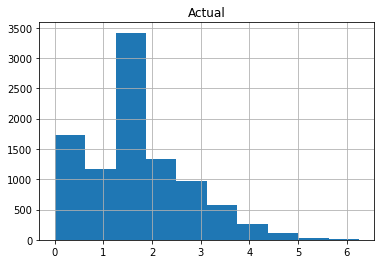

In [4]:
scores.hist()

In [0]:
zip_path = base_dir + '/scored_512.zip'
!cp '{zip_path}' .
!unzip -q scored_512.zip
!rm scored_512.zip

In [0]:
zip_path = base_dir + '/query_512.zip'
!cp '{zip_path}' .
!unzip -q query_512.zip
!rm query_512.zip

In [0]:
class GalaxyDataset(torch.utils.data.Dataset):
    """Galaxy dataset."""

    def __init__(self, csv_file, image_dir, transform=None, mode='train', size=(128, 128), train_split=0.9):
        if mode is "test":
          self.Ids = []
        else:
          self.scores = pd.read_csv(csv_file, index_col="Id")

        self.size = size
        self.samples = []
        self.mode = mode
        if mode == 'train':
          self.scores = self.scores[:int(self.scores.shape[0]*train_split)]
        elif mode == 'val':
          self.scores = self.scores[int(self.scores.shape[0]*train_split):]
        self.image_dir = image_dir
        self.transform = transform

        self.load_dataset()
    def __len__(self):
        return len(self.samples)

    def load_dataset(self):
      print("Loading Dataset...")
      if self.mode == 'test':
        for img_name in os.listdir(self.image_dir):
          if img_name[-3:] == 'png':
            self.samples.append(Image.open(os.path.join(self.image_dir, img_name)).resize(self.size))
            self.Ids.append(img_name[:-4])
      else:
        for id, _ in self.scores.iterrows():
          img_name = os.path.join(self.image_dir,
                                    str(id)+'.png')
          self.samples.append(Image.open(img_name).resize(self.size))
      print("Dataset Loaded")

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.samples[idx]
        if self.mode == 'test':
          return self.transform(image)

        scores = self.scores.iloc[idx]['Actual']
        scores = (scores / 4.0) - 1
        if self.transform is not None:
            image = self.transform(image)

        return (image, scores)

In [0]:
train_transformation = torchvision.transforms.Compose([
                            torchvision.transforms.RandomAffine(30, translate=(0.2, 0.2)),
                            torchvision.transforms.ToTensor()
])
val_transformation = torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor()
])
test_transformation = torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor()
])

In [16]:
train_dataset = GalaxyDataset(base_dir + "/scored.csv", image_dir, transform=train_transformation, mode='train', size=size)
val_dataset = GalaxyDataset(base_dir + "/scored.csv", image_dir, transform=val_transformation, mode='val', size=size)
test_dataset = GalaxyDataset("", test_image_dir, transform=val_transformation, mode='test', size=size)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=1, pin_memory=True, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=1, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=1, pin_memory=True)

Loading Dataset...
Dataset Loaded
Loading Dataset...
Dataset Loaded
Loading Dataset...
Dataset Loaded


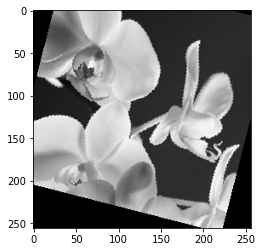

In [17]:
plt.imshow(train_dataset[23][0].numpy().squeeze(), cmap="gray", vmin=0, vmax=1)

In [0]:
class Scorer(nn.Module):
    def __init__(self):
        super(Scorer, self).__init__()

        self.conv1 = nn.Conv2d(1, 64, 3, stride=2, padding=1)
        self.conv1_1 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.conv2_1 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
        self.conv3_1 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 256, 3, stride=2, padding=1)
        self.conv4_1 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        # self.conv5 = nn.Conv2d(256, 512, 3, stride=2, padding=1)
        # self.conv5_1 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        # self.conv6 = nn.Conv2d(512, 512, 3, stride=2, padding=1)
        # self.conv6_1 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.fc1 = nn.Linear(16*16*256, 4096)
        self.fc2 = nn.Linear(4096, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv4_1(x))
        # x = F.relu(self.conv5(x))
        # x = F.relu(self.conv5_1(x))
        # x = F.relu(self.conv6(x))
        # x = F.relu(self.conv6_1(x))
        x = x.view(-1, 16*16*256)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Scorer().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.L1Loss(reduction='mean')
val_loss = torch.nn.L1Loss(reduction='mean')
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.float().to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output.squeeze(), target)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 5 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

epochs = 100
def val(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, target) in enumerate(val_loader):
            data = data.to(device)
            target = target.float().to(device)
            output = model(data)
            test_loss += val_loss(output.squeeze(), target).item()

    test_loss /= len(val_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


for epoch in range(61, 60 + epochs + 1):
    train(epoch)
    val(epoch)

Train Epoch: 61 [0/8640 (0%)]	Loss: 0.001946
Train Epoch: 61 [320/8640 (4%)]	Loss: 0.002218
Train Epoch: 61 [640/8640 (7%)]	Loss: 0.001749
Train Epoch: 61 [960/8640 (11%)]	Loss: 0.001711
Train Epoch: 61 [1280/8640 (15%)]	Loss: 0.002404
Train Epoch: 61 [1600/8640 (19%)]	Loss: 0.001640
Train Epoch: 61 [1920/8640 (22%)]	Loss: 0.002209
Train Epoch: 61 [2240/8640 (26%)]	Loss: 0.001894
Train Epoch: 61 [2560/8640 (30%)]	Loss: 0.001765
Train Epoch: 61 [2880/8640 (33%)]	Loss: 0.001674
Train Epoch: 61 [3200/8640 (37%)]	Loss: 0.001681
Train Epoch: 61 [3520/8640 (41%)]	Loss: 0.002107
Train Epoch: 61 [3840/8640 (44%)]	Loss: 0.001690
Train Epoch: 61 [4160/8640 (48%)]	Loss: 0.001948
Train Epoch: 61 [4480/8640 (52%)]	Loss: 0.001492
Train Epoch: 61 [4800/8640 (56%)]	Loss: 0.001658
Train Epoch: 61 [5120/8640 (59%)]	Loss: 0.001829
Train Epoch: 61 [5440/8640 (63%)]	Loss: 0.001595
Train Epoch: 61 [5760/8640 (67%)]	Loss: 0.001625
Train Epoch: 61 [6080/8640 (70%)]	Loss: 0.001250
Train Epoch: 61 [6400/8640 (7

In [0]:
preds = np.zeros(len(test_dataset))
for i, (data) in enumerate(test_loader):
            data = data.to(device)
            output = model(data)
            output = (output + 1) * 4
            output = torch.clamp(output, 0, 8)
            preds[i*batch_size:i*batch_size + data.shape[0]] = output.cpu().detach().numpy().squeeze()

In [24]:
print(preds.max())
preds.min()

3.362701177597046


0.0

In [0]:
data = np.hstack((np.asarray(test_dataset.Ids).reshape(-1, 1), preds.reshape(-1, 1)))
res = pd.DataFrame(columns=["Id", "Predicted"], data=data)
res.to_csv("res.csv", index=False)

In [0]:
torch.save(model.state_dict(), base_dir + "scorer.model")